In [1]:
import os
import time

import dill
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from chirho.dynamical.handlers import (LogTrajectory, StaticBatchObservation,
                                       StaticIntervention)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root, progress_saver

smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 50 if smoke_test else 250
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 500
num_steps = 10 if smoke_test else 100
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 178770
root = find_repo_root()


notebook_starts = time.time()

In [2]:
locust_count_data_path = os.path.join(
    root, "data/foraging/locust/ds/locust_counts15EQ20191202.pkl"
)

with open(locust_count_data_path, "rb") as f:
    locust_count_data = dill.load(f)

count_data = locust_count_data["count_data"]
init_state = locust_count_data["init_state"]

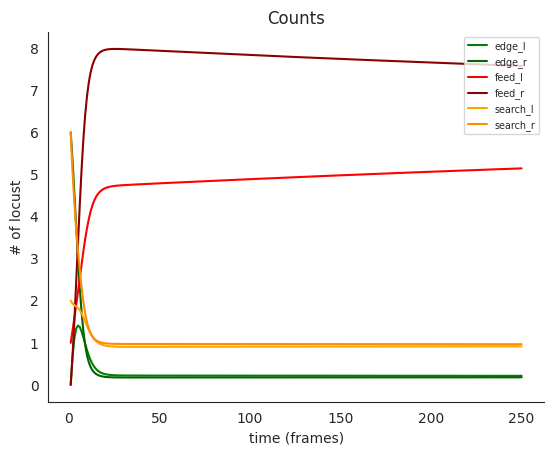

In [3]:
start_time = torch.tensor(1).float()
end_time = torch.tensor(250 + 1).float()
step_size = 1
logging_times = torch.arange(start_time, end_time, step_size)

true_wander = torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
true_attraction = torch.tensor([0.01, 0.01, 0.02, 0.02, 0.06, 0.1, 0.01, 0.01, 0.01])


locust_true = lc.LocustDynamics(true_attraction, true_wander)

with TorchDiffEq(method = 'rk4', options=dict(step_size=1)), LogTrajectory(logging_times) as lt:
    simulate(locust_true, init_state, start_time, end_time)

locust_true_traj = lt.trajectory

ft.plot_ds_trajectories(locust_true_traj, logging_times, window_size=0)

In [23]:
keys = ["edge_l", "edge_r", "search_l", "search_r", "feed_l", "feed_r"]

with pyro.poutine.trace() as tr:
    lc.locust_noisy_model(locust_true_traj)

synthetic_stacked = tr.trace.nodes["counts_obs"]["value"]
assert torch.all(torch.eq(torch.sum(synthetic_stacked, dim=1), 15))


synthetic_data = {f"{key}_obs": tensor for key, tensor in zip(keys, tr.trace.nodes["counts_obs"]["value"].unbind(dim = 1))}
assert count_data.keys() == synthetic_data.keys()



In [39]:
print(synthetic_stacked)
assert synthetic_stacked[0,0]  == synthetic_data["edge_l_obs"][0]
assert torch.equal(synthetic_stacked[:3,3], synthetic_data["search_r_obs"][:3])


tensor([[ 0.,  2.,  2.,  8.,  3.,  0.],
        [ 1.,  3.,  4.,  5.,  1.,  1.],
        [ 3.,  7.,  2.,  0.,  3.,  0.],
        ...,
        [ 0.,  0.,  0.,  0.,  7.,  8.],
        [ 0.,  0.,  0.,  2.,  5.,  8.],
        [ 0.,  1.,  1.,  0.,  3., 10.]], dtype=torch.float64)


ValueError: All arrays must be of the same length

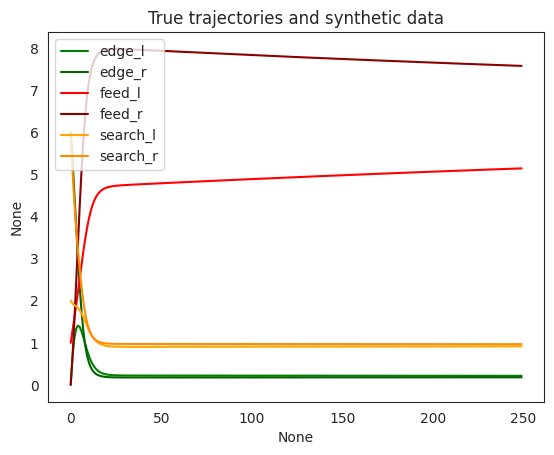

In [12]:
ft.plot_ds_trajectories(
    locust_true_traj,
    window_size=0,
    title="True trajectories and synthetic data",
    scatter_data=synthetic_data,
    scatter_data_type="synthetic",
)